# **MaskTune paper reimplementation**
#### _MaskTune: Mitigating Spurious Correlations by Forcing to Explore (NeurIPS 2022)_
[_paper_](https://arxiv.org/pdf/2210.00055v2),
[_official implementation_](https://github.com/aliasgharkhani/masktune).
[_abstract_](https://arxiv.org/abs/2210.00055v2),
[_papers with code_](https://paperswithcode.com/paper/masktune-mitigating-spurious-correlations-by)

![Method visualization](masktune_method_.png)


#### Reproducing the development environment
- Install Python 3.9.16
- `pip install -r requirements.txt`
- Using Nix flakes, you can use attached `flake.nix` and `flake.lock` to build a shell by running `nix develop` in project root directory

**_NOTE:_** The attached `requirements.txt` file (and therefore the dependecies list for this codebase) is the same as in the official code implementation. This has two effects:
- it minimizes the risk of non-reproducability due to differences in working environment
- it simplifies working with both repositories at the same time 


#### Method description

MaskTune is an automatic (i.e. operating without supervision) method for reducing the effect of over-reliance on a limited number of input features. When that input features are only coincidentally associated with target variables (among others due to data selection bias) the phenomenon is called _spurious correlation_. The method works by one-epoch finetuning the model on data with the most discriminatory input features masked out. A treshhold is applied on contribution-to-prediction heatmap, which the authors of the work have established best to be `m+2s`, where `m` and `s` are heatmap's mean and standard deviation for a single sample. Authors also mention the possibility of applying the method iteratively until a satisfactory condition isn't met.


#### Required imports
Matplotlib is configured to work inline in Jupyter notebook

In [1]:
import os

import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
import torch.optim as optim
from pytorch_grad_cam import XGradCAM
from tqdm import tqdm

from src.datasets import SpuriousMNIST
from src.models import SmallCNN, ResNet50

#### Checkpointing
There is a mechanism of training progress checkpointing. The model's and optimizer's states as well as epoch are recored every 5 iterations of training (and at the end) and saved to file .

In [2]:
checkpoint_prefix = 'checkpoints/'

def checkpoint(checkpoint_path, model, optimizer):
    checkpoint_path = os.path.join(checkpoint_prefix, checkpoint_path)
    if os.path.exists(checkpoint_path):
        checkpoint_data = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint_data['model'])
        optimizer.load_state_dict(checkpoint_data['optimizer'])
        epoch = checkpoint_data['epoch']
        return epoch # epoch to resume from
    else:
        return 0
    
def save_checkpoint(checkpoint_path, model, optimizer, epoch):
    checkpoint_path = os.path.join(checkpoint_prefix, checkpoint_path)
    checkpoint_data = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch,
    }
    torch.save(checkpoint_data, checkpoint_path)

### Results
- The implementation below shows that the MaskTune method indeed allows for reducing the dependency of the model on spurious features. 
- In my attempts, the accuracy on malicious set (the set with spurious feature occurence flipped between two classes, in paper called _biased test set_) before applying MaskTune method was significantly higher (usually around 80%) than in the paper (18.59%).
- However, by decreasing the ratio of spurious feature miss-occurence (ratio of samples where given its class it should/n't have the spurious feature) from 1% to 0%, which in turn tighten the correlation between spurious feature and class assignment, I was able to achieve superior results after applying MaskTune (from 50% and 0% accuracy on raw and malicious test sets respectively to 98% on both).

#### General train method

In [3]:
def train(model, dataloader, optimizer, lr_schedule, epoch, checkpoint_path):
    for learning_rate in lr_schedule[epoch:]:
        optimizer.lr = learning_rate
        progress = tqdm(dataloader)
        for inputs, targets in progress:
            progress.set_description(f'lr {learning_rate} epoch {epoch}')
            inputs, targets = inputs.to('cuda'), targets.to('cuda')
            optimizer.zero_grad()
            predictions = model(inputs)
            loss = torch.nn.functional.cross_entropy(predictions, targets)
            loss.backward()
            optimizer.step()
        epoch += 1
        if epoch % 5 == 0 or epoch == len(lr_schedule): save_checkpoint(checkpoint_path, model, optimizer, epoch)

#### Masking calculation
`masking_function` is a curried function (i.e. one that is possible to partially apply):
- we apply only a model argument when we want to pass function on data to dataset,
- we apply fully when calculating heatmaps for visualization.

In [4]:
def masking_function(model):
    xgradcam = XGradCAM(model=model, target_layers=model.target_layer(), use_cuda=True)
    
    def maskf(data):
        # COPYPASTE FROM OFFICIAL IMPLEMENTATION
        heat_maps = xgradcam(data)
        mask_mean_value = np.nanmean(
            np.where(heat_maps > 0, heat_maps, np.nan), axis=(1, 2))[:, None, None]
        mask_std_value = np.nanstd(
            np.where(heat_maps > 0, heat_maps, np.nan), axis=(1, 2))[:, None, None]
        mask_threshold_value = mask_mean_value + 2 * mask_std_value
        mask = np.expand_dims(np.where(heat_maps > mask_threshold_value, 0, 1), axis=-3)
        return data * mask, heat_maps

    return maskf

In [5]:
def visualize(comment, model, dataloader, batch=10):
    print(comment)
    fig, axs = plt.subplots(2, batch, figsize=(2*batch, 4))
    labels = []
    predictions = []
    for i in range(batch):
        axs[0][i].imshow(dataloader.dataset[i][0].permute(1, 2, 0))
        _, heat_map = masking_function(model)(dataloader.dataset[i][0].unsqueeze(0))
        axs[1][i].imshow(heat_map.squeeze(0))
        axs[0][i].axis('off')
        axs[1][i].axis('off')
        labels.append(dataloader.dataset[i][1])
        predictions.append(model(dataloader.dataset[i][0].unsqueeze(0).to('cuda')).argmax().item())
    plt.show()
    print(f'Labels:      {labels}')
    print(f'Predictions: {predictions}')

def test(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to('cuda'), targets.to('cuda')
            predictions = model(inputs)
            _, predicted = torch.max(predictions, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return correct / total

def complete_test(model, train_dl, raw_dl, malicious_dl):
    visualize("Visualization on Training Dataset", model, train_dl)
    visualize("Visualization on Test Raw Dataset", model, raw_dl)
    visualize("Visualization on Test Malicious Dataset", model, malicious_dl)
    print(f'Train accuracy: {test(model, train_dl)}')
    print(f'Raw accuracy: {test(model, raw_dl)}')
    print(f'Malicious accuracy: {test(model, malicious_dl)}')

#### Classification on MNIST with spurious features
Main code responsible for paper logic reproduction

Evaluating Masktune on SpuriousMNIST with class mix ratio 0.01


/home/marcin/neural-networks-project/Masktune/solution/.venv/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Before Masktune
Visualization on Training Dataset


/home/marcin/neural-networks-project/Masktune/solution/.venv/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


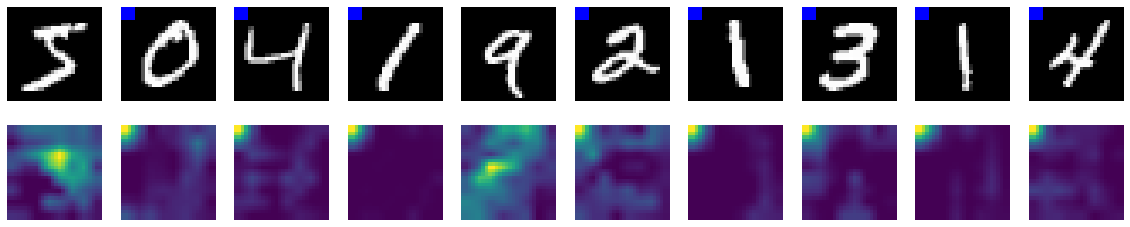

Labels:      [1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Predictions: [1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Visualization on Test Raw Dataset


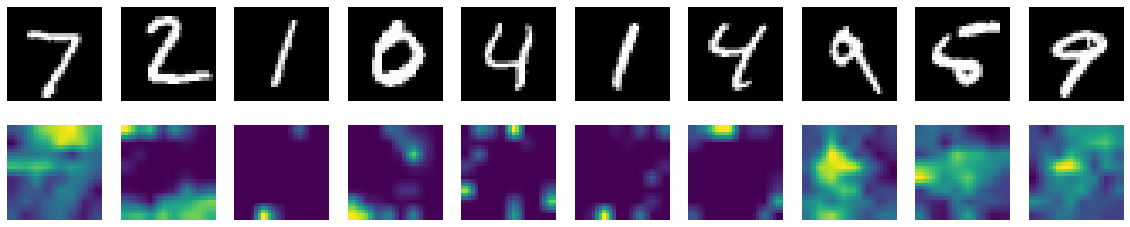

Labels:      [1, 0, 0, 0, 0, 0, 0, 1, 1, 1]
Predictions: [1, 0, 0, 0, 0, 0, 0, 1, 1, 1]
Visualization on Test Malicious Dataset


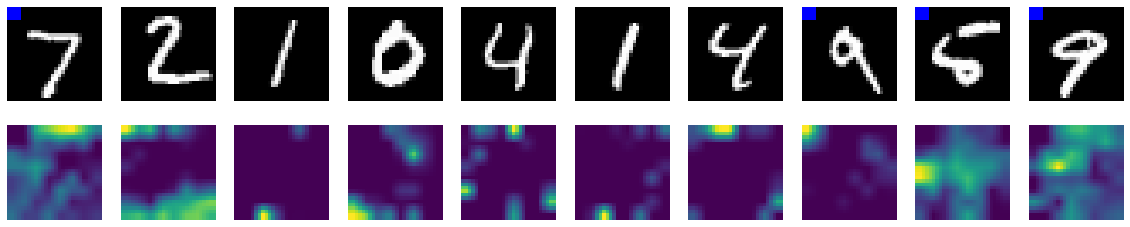

Labels:      [1, 0, 0, 0, 0, 0, 0, 1, 1, 1]
Predictions: [1, 0, 0, 0, 0, 0, 0, 0, 1, 1]
Train accuracy: 0.9982666666666666
Raw accuracy: 0.9236
Malicious accuracy: 0.8405


Masking data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:19<00:00, 24.03it/s]


After Masktune
Visualization on Training Dataset


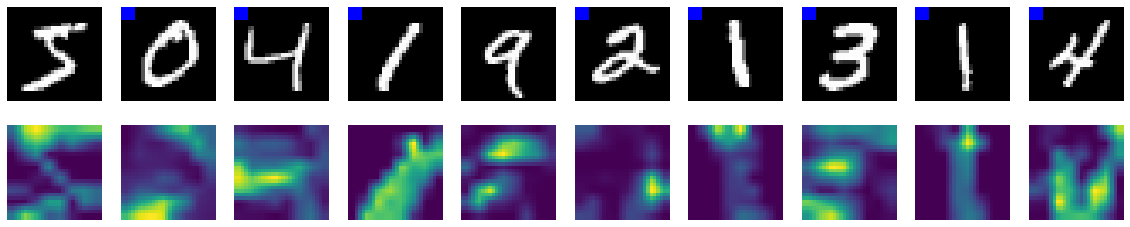

Labels:      [1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Predictions: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Visualization on Test Raw Dataset


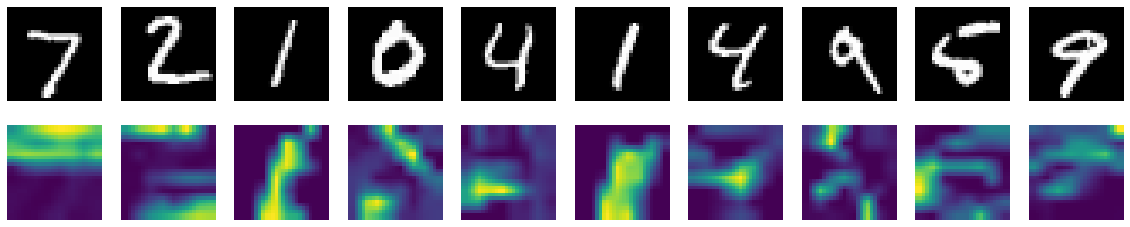

Labels:      [1, 0, 0, 0, 0, 0, 0, 1, 1, 1]
Predictions: [1, 0, 0, 0, 0, 0, 0, 0, 1, 1]
Visualization on Test Malicious Dataset


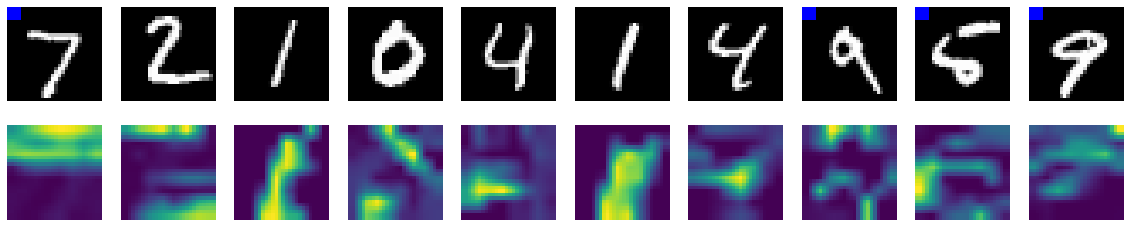

Labels:      [1, 0, 0, 0, 0, 0, 0, 1, 1, 1]
Predictions: [1, 0, 0, 0, 0, 0, 0, 0, 1, 1]
Train accuracy: 0.9470833333333334
Raw accuracy: 0.9465
Malicious accuracy: 0.9466
Evaluating Masktune on SpuriousMNIST with class mix ratio 0.0
Before Masktune
Visualization on Training Dataset


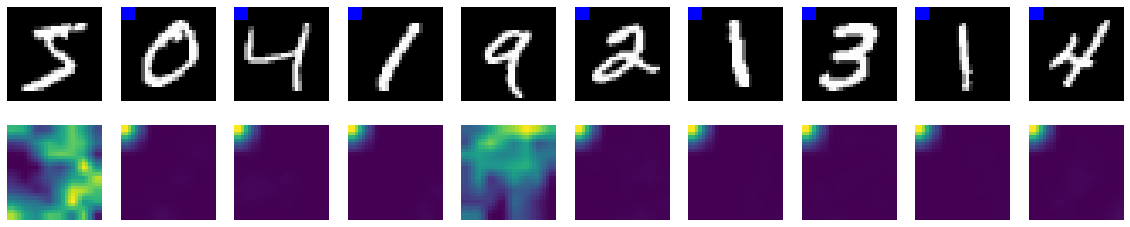

Labels:      [1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Predictions: [1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Visualization on Test Raw Dataset


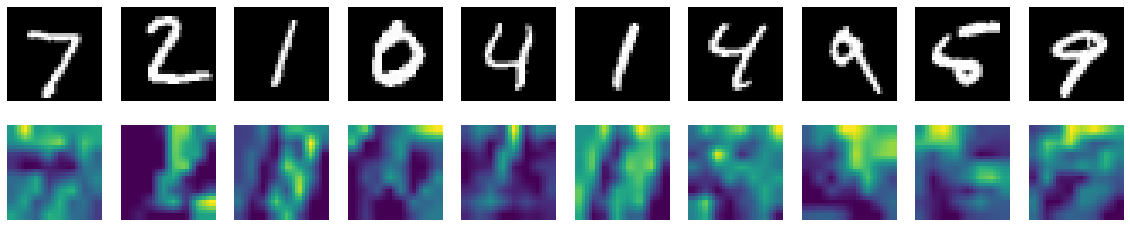

Labels:      [1, 0, 0, 0, 0, 0, 0, 1, 1, 1]
Predictions: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Visualization on Test Malicious Dataset


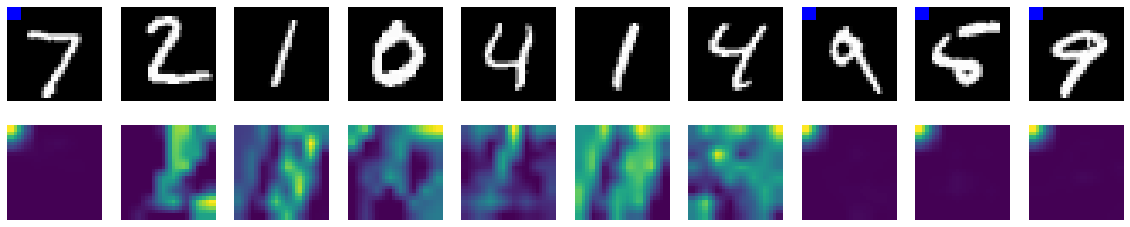

Labels:      [1, 0, 0, 0, 0, 0, 0, 1, 1, 1]
Predictions: [0, 1, 1, 1, 1, 1, 1, 0, 0, 0]
Train accuracy: 1.0
Raw accuracy: 0.4861
Malicious accuracy: 0.0


Masking data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:19<00:00, 24.21it/s]


After Masktune
Visualization on Training Dataset


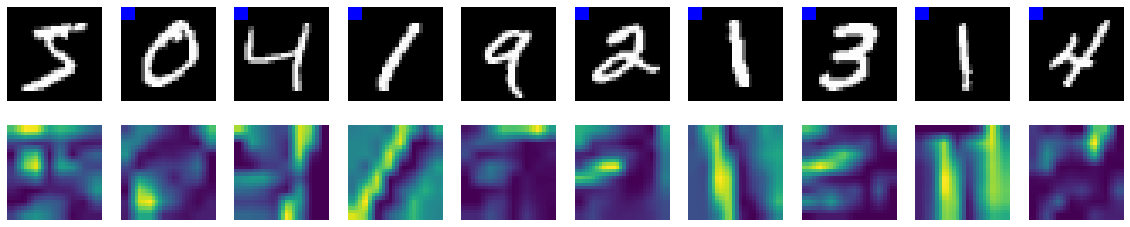

Labels:      [1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Predictions: [1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Visualization on Test Raw Dataset


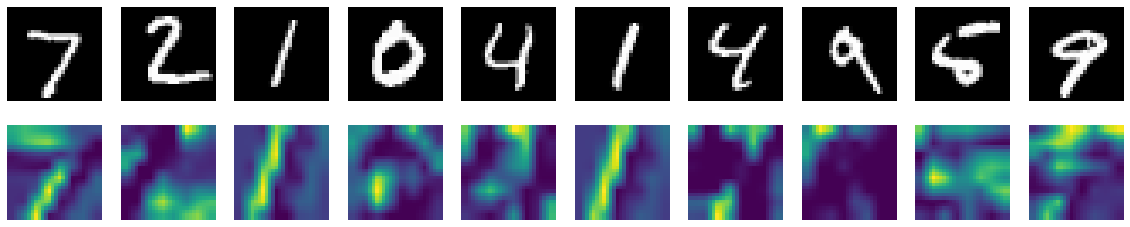

Labels:      [1, 0, 0, 0, 0, 0, 0, 1, 1, 1]
Predictions: [1, 0, 0, 0, 0, 0, 0, 1, 1, 1]
Visualization on Test Malicious Dataset


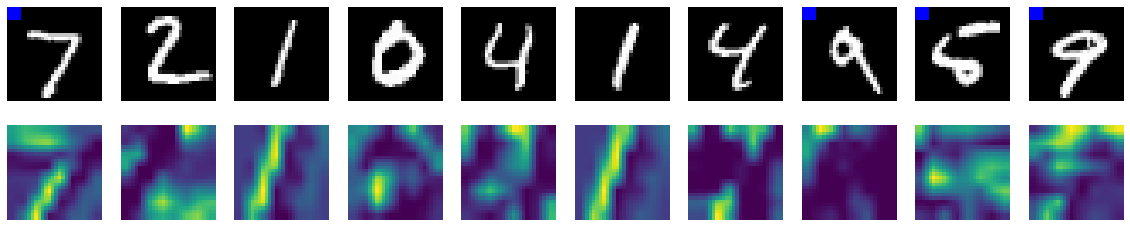

Labels:      [1, 0, 0, 0, 0, 0, 0, 1, 1, 1]
Predictions: [1, 0, 0, 0, 0, 0, 0, 1, 1, 1]
Train accuracy: 0.9806666666666667
Raw accuracy: 0.9795
Malicious accuracy: 0.9795


In [6]:
for class_mix_ratio in [0.01, 0.0]:
    
    class_mix_ratio_str = str(class_mix_ratio).replace('0.', '')
    print(f'Evaluating Masktune on SpuriousMNIST with class mix ratio {str(class_mix_ratio)}')

    checkpoint_path = f'train_mnist_erm_mix_{class_mix_ratio_str}.pt'
    model = SmallCNN(num_classes=2)
    model.to('cuda')
    optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=0.01, weight_decay=1e-4)
    epoch = checkpoint(checkpoint_path, model, optimizer) 
    lr_schedule = np.repeat([0.01, 0.005, 0.0025, 0.00125], 25)

    train_dataloader = torch.utils.data.DataLoader(
        SpuriousMNIST(root='./data', train=True, download=True, class_mix_ratio=class_mix_ratio),
        batch_size=128, # from paper
        shuffle=True, num_workers=8,
    )
    train(model, train_dataloader, optimizer, lr_schedule, epoch, checkpoint_path)


    test_raw_dataloader = torch.utils.data.DataLoader(
        SpuriousMNIST(root='./data', train=False, test_set='raw', download=True),
        batch_size=128, # from paper
        shuffle=True, num_workers=8,
    )
    test_malicious_dataloader = torch.utils.data.DataLoader(
        SpuriousMNIST(root='./data', train=False, test_set='malicious', download=True),
        batch_size=128, # from paper
        shuffle=True, num_workers=8,
    )

    print('Before Masktune')
    complete_test(model, train_dataloader, test_raw_dataloader, test_malicious_dataloader)

    checkpoint_path = f'masktune_mnist_mix_{class_mix_ratio_str}.pt'
    epoch = checkpoint(checkpoint_path, model, optimizer)
    mask_dataloader = torch.utils.data.DataLoader(
        SpuriousMNIST(root='./data', train=True, download=True, mask_func=masking_function(model)),
        batch_size=128, # from paper
        shuffle=True, num_workers=8,
    )
    train(model, mask_dataloader, optimizer, [0.00125], epoch, checkpoint_path)

    print('After Masktune')
    complete_test(model, train_dataloader, test_raw_dataloader, test_malicious_dataloader)

#### The Background Challenge, CelebA, Waterbirds and the rest

Unfortunately, I don't have continuous access to GPU to be able to train large computer vision models like ResNet32 or ResNet50, therefore I must stop here.

In [7]:
'''
model = ResNet50()
train_dataloader = torch.utils.data.DataLoader(
    TODO,
    batch_size=128, # from paper
    shuffle=True, num_workers=8,
)
test_dataloader = torch.utils.data.DataLoader(
    TODO,
    batch_size=128, # from paper
    shuffle=True,
    num_workers=8,
)
'''

'\nmodel = ResNet50()\ntrain_dataloader = torch.utils.data.DataLoader(\n    TODO,\n    batch_size=128, # from paper\n    shuffle=True, num_workers=8,\n)\ntest_dataloader = torch.utils.data.DataLoader(\n    TODO,\n    batch_size=128, # from paper\n    shuffle=True,\n    num_workers=8,\n)\n'